In [1]:
import gymnasium
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from utils import visualise_pricing_strategy, visualise_episode_rewards,visualise_demand_data
from Pricing_Environment import demand_calculator ,pricing_env
from agents import MarkovDecisionProcess,QLearningAgent,UCB
import random
random.seed(42)
np.random.seed(42)


### Config Section

In [2]:
product_config = {
    "min_price": 10,
    "max_price": 100,
    "initial_demand": 0.5
}

demand_calculator_config = {
    "price_probability_ranges": {
        (0, 1): 0.8,   # High probability of demand for lower prices
        (1, 2): 0.6    # Lower probability as prices increase
    },
    'low': 0,
    'high': 2,
    'steps': 5,
    'seasonality': True
}

action_strategy_config = {
    "action_probabilities": {
        0: 0.1,  # Decrease price significantly
        1: 0.2,  # Decrease price slightly
        2: 0.4,  # Keep price
        3: 0.2,  # Increase price slightly
        4: 0.1   # Increase price significantly
    },
    "price_change_map": {
        0: -10,  # Decrease significantly
        1: -5,   # Decrease slightly
        2: 0,    # Keep price
        3: 5,    # Increase slightly
        4: 10    # Increase significantly
    }
}


In [3]:
def encode_state(market_demand, boundaries):
    """
    Encodes the market demand into a discrete state based on specified boundaries.

    Args:
        market_demand (float): The current market demand from the environment's state.
        boundaries (list of floats): The boundaries between different demand bins. Should be sorted in ascending order.

    Returns:
        int: A discrete integer representing the encoded state. Returns the index of the bin into which the market demand falls.
    """
    # Iterate over the boundaries to determine the correct bin
    for i, boundary in enumerate(boundaries):
        if market_demand < boundary:
            return i
    # If the demand is greater than all boundaries, return the last bin index
    return len(boundaries)

In [4]:
# Function to plot episode rewards for each agent type
def visualize_episode_rewards(episode_rewards):
    plt.figure(figsize=(12, 8))
    for agent_key, rewards in episode_rewards.items():
        plt.plot(rewards, label=f'Rewards: {agent_key}', marker='o')
    
    plt.title('Rewards Per Episode for Each Agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

#visualize_episode_rewards(episode_rewards)


Simulating Markov Decision Process Agent


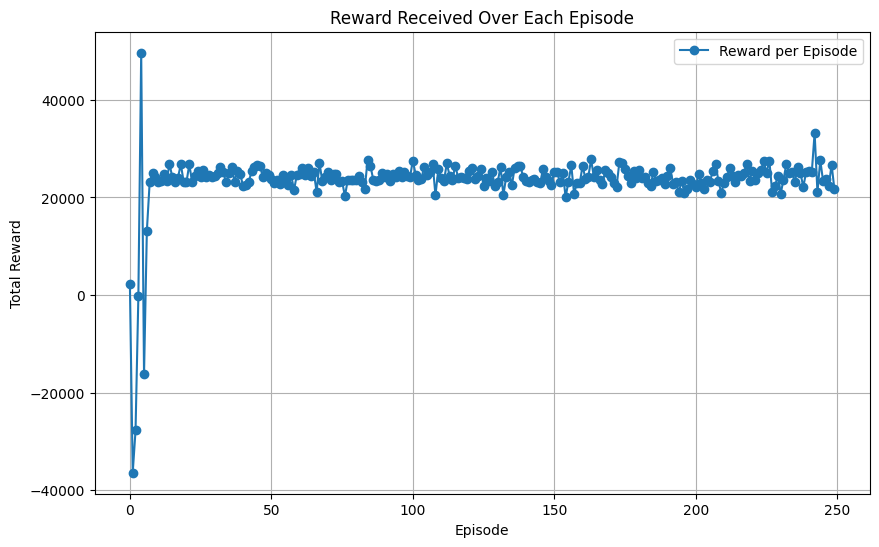

Simulating Q-Learning Agent


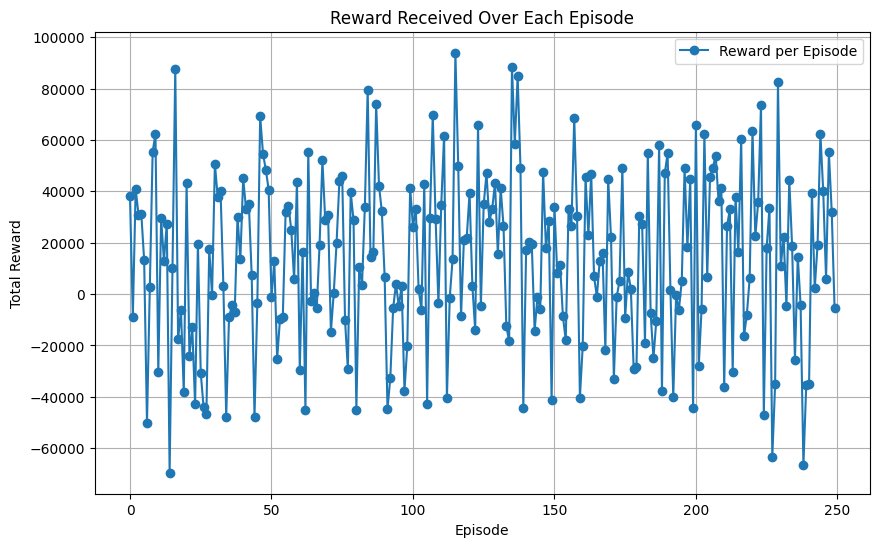

Simulating UCB Agent


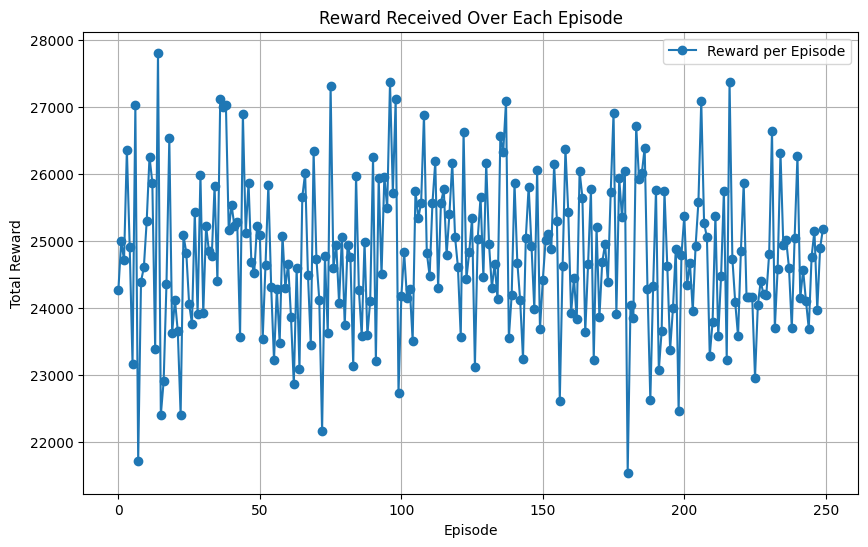

In [13]:
product_config = {
    "min_price": 10,
    "max_price": 100,
    "initial_demand": 0.5
}

demand_calculator_config = {
    "price_probability_ranges": {
        (0, 1): 0.8,   # High probability of demand for lower prices
        (1, 2): 0.6    # Lower probability as prices increase
    },
    'low': 0,
    'high': 2,
    'steps': 5,
    'seasonality': True
}

action_strategy_config = {
    "action_probabilities": {
        0: 0.1,  # Decrease price significantly
        1: 0.2,  # Decrease price slightly
        2: 0.4,  # Keep price
        3: 0.2,  # Increase price slightly
        4: 0.1   # Increase price significantly
    },
    "price_change_map": {
        0: -10,  # Decrease significantly
        1: -5,   # Decrease slightly
        2: 0,    # Keep price
        3: 5,    # Increase slightly
        4: 10    # Increase significantly
    }
}

num_episodes = 25
max_steps_per_episode = 500

env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=False, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)
demand_generator = pricing_env.DemandDataGenerator(
    low=demand_calculator_config['low'],
    high=demand_calculator_config['high'],
    steps=max_steps_per_episode,
    seasonality=True
)

# Define expanded boundaries for market demand bins
boundaries = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]  # Increased granularity
state_size = len(boundaries) + 1  # plus one for demands above the highest boundary


# Setup and run simulations for MarkovDecisionProcess
print("Simulating Markov Decision Process Agent")
mdp_agent = MarkovDecisionProcess(action_strategy_config['action_probabilities'])
mdp_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = mdp_agent.choose_action()  # Use choose_action for MDP
        demand = demand_generator.generate()[step % demand_generator.steps]
        next_state, reward, done, _ = env.step(action, demand)
        mdp_agent.update_probabilities(action, reward)  # Update MDP strategy
        
        total_reward += reward
        if done:
            break
    mdp_rewards.append(total_reward)
    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")

visualise_episode_rewards(mdp_rewards)


q_learning_agent = QLearningAgent(state_size=state_size, action_size=5)

q_learning_rewards = []


print("Simulating Q-Learning Agent")
for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Assuming the market demand is the first element of the state
    state = encode_state(market_demand, boundaries)  # Encode the initial state
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = q_learning_agent.act(state)
        demand = demand_generator.generate()[step % demand_generator.steps]  # Using the demand data generator
        raw_next_state, reward, done, _ = env.step(action, demand)
        next_market_demand = raw_next_state[0]  # Assuming the market demand is the first element of the next state
        next_state = encode_state(next_market_demand, boundaries)  # Encode the next state

        q_learning_agent.update(state, action, reward, next_state, done)  # Update Q-learning agent
        state = next_state
        total_reward += reward
        if done:
            break
    
    q_learning_rewards.append(total_reward)
    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")

# Visualization function to plot the rewards after all episodes
visualise_episode_rewards(q_learning_rewards)

# Setup and run simulations for UCB1 Agent
print("Simulating UCB Agent")
ucb_agent = UCB(len(action_strategy_config['action_probabilities']))
ucb_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = ucb_agent.select_action()  # Use select_action for UCB1
        demand = demand_generator.generate()[step % demand_generator.steps]
        next_state, reward, done, _ = env.step(action, demand)
        ucb_agent.update(action, reward)  # Update UCB agent
        
        total_reward += reward
        if done:
            break
    ucb_rewards.append(total_reward)
    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")

visualise_episode_rewards(ucb_rewards)



Simulating Q-Learning Agent


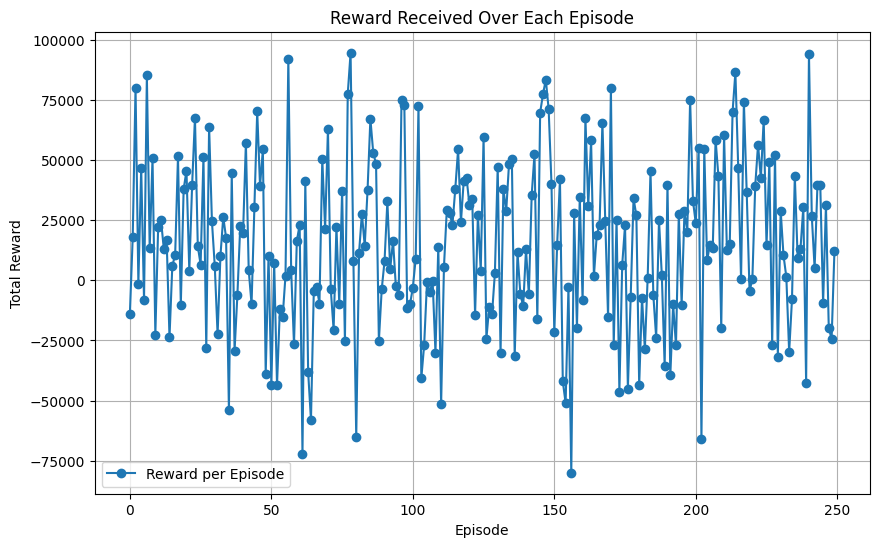

In [14]:

num_episodes = 250
max_steps_per_episode = 500
q_learning_rewards = []
print("Simulating Q-Learning Agent")
for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Assuming the market demand is the first element of the state
    state = encode_state(market_demand, boundaries)  # Encode the initial state
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = q_learning_agent.act(state)
        demand = demand_generator.generate()[step % demand_generator.steps]  # Using the demand data generator
        raw_next_state, reward, done, _ = env.step(action, demand)
        next_market_demand = raw_next_state[0]  # Assuming the market demand is the first element of the next state
        next_state = encode_state(next_market_demand, boundaries)  # Encode the next state

        q_learning_agent.update(state, action, reward, next_state, done)  # Update Q-learning agent
        state = next_state
        total_reward += reward
        if done:
            break
    
    q_learning_rewards.append(total_reward)
    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")

# Visualization after completing all episodes
visualise_episode_rewards(q_learning_rewards)

In [26]:
demand_generator.generate()

array([159.        , 173.25230998, 187.50445932, 113.75628746,
       199.00763407, 153.25833912, 130.50824297, 130.75718652,
       158.00501126, 186.25155941, 128.49667397, 141.74019889,
       123.98197911, 183.22186069, 142.4596909 , 131.69531831,
       152.92859289, 176.15936612, 114.38749106, 189.61282246,
       156.83521686, 136.05453266, 144.27063021, 159.48337192,
       115.69262235, 106.89824826, 148.10011873, 180.29810522,
       194.49208168, 122.6819246 , 118.86751311, 203.04872904,
       203.22545702, 202.39758451, 183.56500193, 200.72760267,
       203.88528322, 165.03794316, 183.18548532, 178.32781573,
       200.46484379, 170.59648224, 200.72264727, 156.84325856,
       122.9582393 , 188.06751628, 154.17101994, 166.26868437,
       157.36044738, 163.44625055, 191.52603925, 143.59976268,
       163.66737389, 193.72882985, 175.78409141, 130.8331234 ,
       162.87589459, 150.91237775, 198.94254966, 120.9663911 ,
       206.98388689, 123.99502589, 197.99980102, 148.99